In [4]:
import os
import pickle
import time

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch

from collab.foraging import locust as lc
from collab.foraging import toolkit as ft
from collab.utils import find_repo_root

root = find_repo_root()


smoke_test = "CI" in os.environ
smoke_test = True
subset_starts = 420
subset_ends = 480
desired_frames = 100 if smoke_test else 900
num_iterations = 50 if smoke_test else 2000
num_samples = 20 if smoke_test else 1000
sample_size = 100 if smoke_test else 1000
locust_sample_size = 100 if smoke_test else 178770


# setting developer mode to True
# will force full selected set to be used
# in the learning
# and run the training
developer_mode = False
if developer_mode:
    smoke_test = False

notebook_starts = time.time()

In [6]:
locust_data_path = os.path.join(root, "data/foraging/locust/15EQ20191202_tracked.csv")

df = lc.load_and_clean_locust(
    path=locust_data_path,
    desired_frames=desired_frames,
    grid_size=45,
    rewards_x=[0.68074, -0.69292],
    rewards_y=[-0.03068, -0.03068],
    subset_starts=420,  # subset_starts,
    subset_ends=480,  # subset_ends,
)

loc_subset = df["subset"]
loc_all = df["all_frames"]

loc_subset.foragersDF["time"].unique()

original_frames: 45000
original_shape: (675000, 4)
resulting_frames: 100
resulting_shape: (1500, 4)
min_time 1
max_time 100
frames diff 60
desired_frames 100


ValueError: max() arg is an empty sequence

In [3]:
# uncomment this if you're interested in processing the whole dataset
# instead of the subsample

# start_time = time.time()
# loc_all = ft.derive_predictors(loc_all, sampling_rate= .1)
# end_time = time.time()
# print("time taken", end_time - start_time)
# takes about 5 minutes to process the whole dataset
# with sampling rate .1

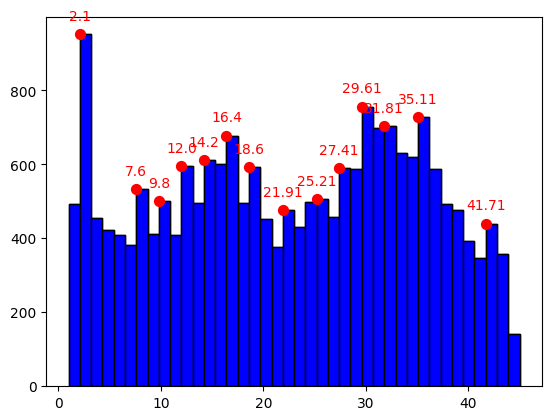

In [7]:
locust_distances = ft.foragers_to_forager_distances(loc_subset)
ft.distances_and_peaks(locust_distances)

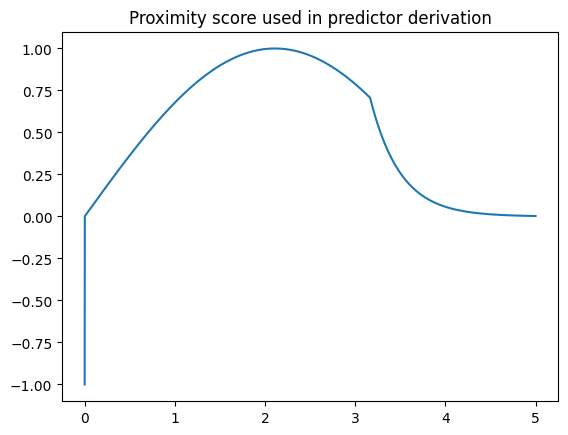

In [8]:
# this illustrates the proximity function that we will use
# in predictor derivation

start = 0.0
end = 5.0
step = 0.001
x = [start + i * step for i in range(int((end - start) / step) + 1)]
y = [
    ft.proximity_score(_d, getting_worse=0.0001, optimal=2.11, proximity_decay=3)
    for _d in x
]
plt.plot(x, y)
plt.title("Proximity score used in predictor derivation")

plt.show()

In [9]:
loc_subset = ft.derive_predictors(
    loc_subset,
    rewards_decay=0.4,
    visibility_range=90,
    getting_worse=0.001,
    optimal=2.11,
    proximity_decay=3,
    generate_communicates_indicator=True,
    info_time_decay=10,
    info_spatial_decay=0.1,
    finders_tolerance=2,
    time_shift=subset_starts - 1,
    sampling_rate=0.1,
    restrict_to_invisible=False,
)

2024-02-29 12:37:12,291 - traces done
2024-02-29 12:37:14,897 - visibility done
2024-02-29 12:37:25,996 - proximity done
2024-02-29 12:37:27,163 - how_far done
2024-02-29 12:37:27,830 - derivedDF done
2024-02-29 12:37:27,830 - starting to generate communicates
2024-02-29 12:37:57,359 - communicates done


In [10]:
loc_subset.derivedDF.shape
loc_subset.derivedDF.isna().sum()

x                           0
y                           0
trace                       0
time                        0
trace_standardized          0
distance                    0
distance_x                  0
distance_y                  0
visibility                  0
forager                     0
proximity                   0
proximity_standardized      0
how_far_squared             0
how_far_squared_scaled      0
communicate                 0
communicate_standardized    0
dtype: int64

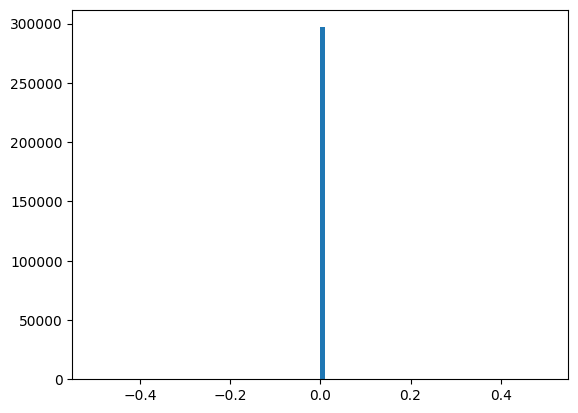

In [20]:
plt.hist(loc_subset.derivedDF["communicate_standardized"], bins=100)
plt.show()

In [19]:
ft.animate_foragers(
    loc_subset,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_communicate=1,
    plot_traces=True,
    trace_multiplier=15,
    communicate_multiplier=1,
)

In [11]:
loc_subset_robust = ft.prep_data_for_robust_inference(
    loc_subset, gridsize=9
)  # modifies loc_subset in place as well

In [12]:
data = ft.get_tensorized_data(loc_subset)

proximity, trace, visibility, communicate, how_far = (
    data["proximity_standardized"],
    data["trace_standardized"],
    data["visibility"],
    data["communicate_standardized"],
    data["how_far"],
)

# todo refactor
# ft.visualise_forager_predictors(trace, proximity, how_far, com=communicate)

Initial dataset size: 296940
Complete cases: 0


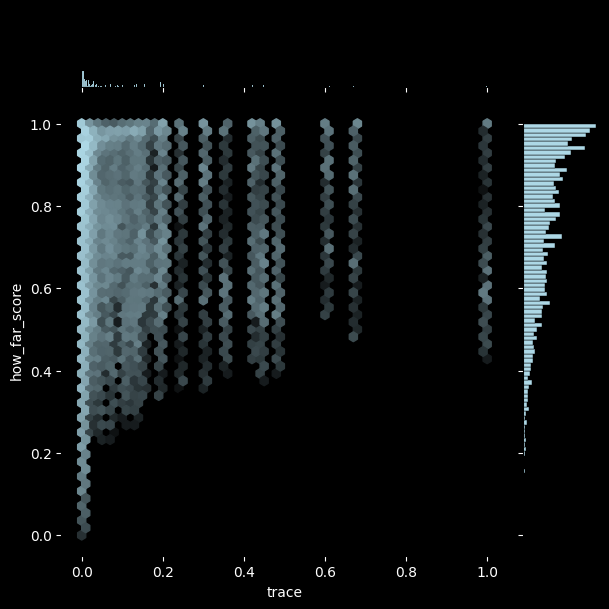

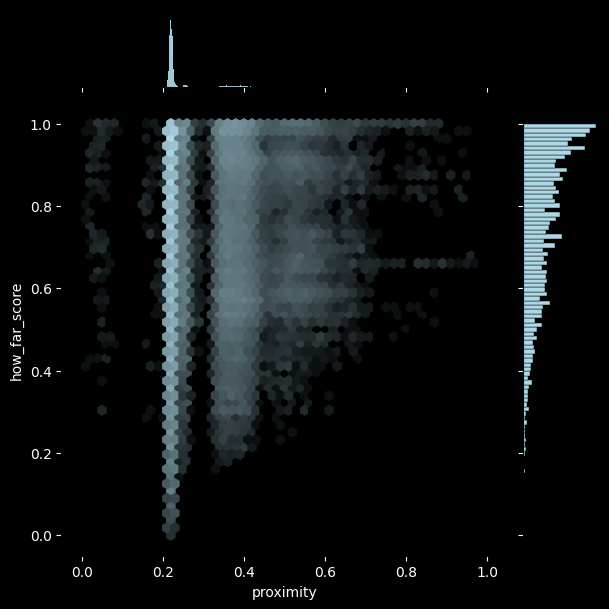

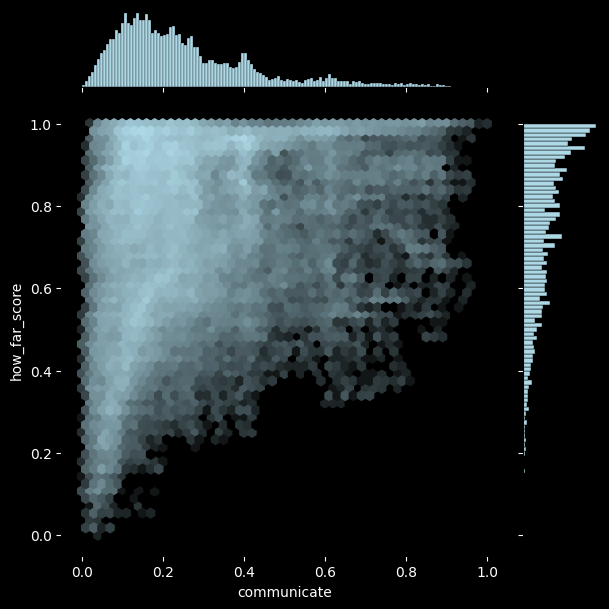

In [13]:
# todo build into the toolkit
x_to_plot = [trace, proximity, communicate]
x_labels = ["trace", "proximity", "communicate"]
y = how_far

# if seaborn gives deprecation warnings, here's a hacky fix
# import warnings
# warnings.simplefilter(action="ignore", category=FutureWarning)

Colors = ["black", "lightblue"]
cmap = colors.LinearSegmentedColormap.from_list("blackToBlue", Colors)

for idx, x in enumerate(x_to_plot):
    # Create the jointplot
    g = sns.jointplot(
        x=x,
        y=y,
        kind="hex",
        gridsize=50,
        cmap=cmap,
        norm=colors.LogNorm(),
        joint_kws=dict(facecolor="k"),
        marginal_kws=dict(facecolor="lightblue", edgecolor="black"),
    )

    # Set the main plot and marginal histograms background to black
    g.ax_joint.set_facecolor("black")
    g.ax_marg_x.set_facecolor("black")
    g.ax_marg_y.set_facecolor("black")

    # Set the background of the entire figure to black
    g.fig.set_facecolor("black")

    # Set axis labels
    g.set_axis_labels(x_labels[idx], "how_far_score", color="white")

    # Set tick labels to white for visibility against the black background
    g.ax_joint.tick_params(axis="both", colors="white")
    g.ax_marg_x.tick_params(axis="x", colors="white")
    g.ax_marg_y.tick_params(axis="y", colors="white")

    plt.show()

In [14]:
locust = loc_subset.derivedDF

locust["proximity_id"] = locust.proximity_cat.astype("category").cat.codes
locust["trace_id"] = locust.trace_cat.astype("category").cat.codes
locust["communicate_id"] = locust.communicate_cat.astype("category").cat.codes
locust["how_far"] = locust.how_far_squared_scaled

In [15]:
locust_sample_size = len(locust) if not smoke_test else 10
locust_subsample = locust.sample(n=locust_sample_size, random_state=42)


locust_tensorized = {}

locust_tensorized["how_far"] = torch.tensor(
    locust_subsample["how_far"].values, dtype=torch.float32
)
locust_tensorized["proximity"] = torch.tensor(
    locust_subsample["proximity_standardized"].values, dtype=torch.float32
)
locust_tensorized["trace"] = torch.tensor(
    locust_subsample["trace_standardized"].values, dtype=torch.float32
)
locust_tensorized["communicate"] = torch.tensor(
    locust_subsample["communicate_standardized"].values, dtype=torch.float32
)

# potentially useful for robust inference, not needed for now
# missing_categories = {}
# def list_empty_categories(column):
#     return list(column.cat.categories[column.value_counts().eq(0)].values)


# columns_to_clean_categories = ["proximity_id", "trace_id", "communicate_id"]
# for column in columns_to_clean_categories:
#     locust_subsample[column] = locust_subsample.proximity_cat.astype("category")
#     missing_categories[column] = list_empty_categories(locust_subsample[column])
#     locust_subsample[column] = locust_subsample[column].cat.remove_unused_categories()
#     locust_subsample[column] = locust_subsample[column].cat.codes.values

#     locust_tensorized[column] = torch.tensor(
#         locust_subsample[column].values, dtype=torch.int32
#     )

In [16]:
how_far_tensor = locust_tensorized["how_far"]
proximity_tensor = locust_tensorized["proximity"]
communicate_tensor = locust_tensorized["communicate"]
trace_tensor = locust_tensorized["trace"]
# not using visibility as locust see everything in the area


def continuous_model(
    proximity_tensor, trace_tensor, communicate_tensor, how_far_tensor
):
    bias = pyro.sample("bias", dist.Normal(0.5, 0.3))
    p = pyro.sample("p", dist.Normal(0.0, 0.2))
    t = pyro.sample("t", dist.Normal(0.0, 0.2))
    c = pyro.sample("c", dist.Normal(0.0, 0.2))

    sigma_bias = pyro.sample("sigma_bias", dist.Exponential(7))
    p_sigma = pyro.sample("p_sigma", dist.Exponential(7))
    t_sigma = pyro.sample("t_sigma", dist.Exponential(7))
    c_sigma = pyro.sample("c_sigma", dist.Exponential(7))

    with pyro.plate("data", len(how_far_tensor)):
        sigma = pyro.deterministic(
            "sigma",
            sigma_bias
            + p_sigma * proximity_tensor
            + t_sigma * trace_tensor
            + c_sigma * communicate_tensor,
        )

        mean = pyro.deterministic(
            "mean",
            bias + p * proximity_tensor + t * trace_tensor + c * communicate_tensor,
        )

        how_far_observed = pyro.sample(
            "how_far_observed", dist.Normal(mean, sigma), obs=how_far_tensor
        )

Step 0/2000, Loss: 1070653.3252545595
Step 100/2000, Loss: 80609.14698964357
Step 200/2000, Loss: -259306.43101775646
Step 300/2000, Loss: -228149.89241623878
Step 400/2000, Loss: -271434.9836472869
Step 500/2000, Loss: -260716.53598344326
Step 600/2000, Loss: -314363.3018839359
Step 700/2000, Loss: -333473.8483541608
Step 800/2000, Loss: -330057.8672552109
Step 900/2000, Loss: -325815.05840051174
Step 1000/2000, Loss: -335303.2756819725
Step 1100/2000, Loss: -327039.25496804714
Step 1200/2000, Loss: -307519.8157939911
Step 1300/2000, Loss: -336527.72242307663
Step 1400/2000, Loss: -333329.4632960558
Step 1500/2000, Loss: -336230.0098311901
Step 1600/2000, Loss: -335089.695533514
Step 1700/2000, Loss: -310723.5308111906
Step 1800/2000, Loss: -337747.41316509247
Step 1900/2000, Loss: -317805.80767953396


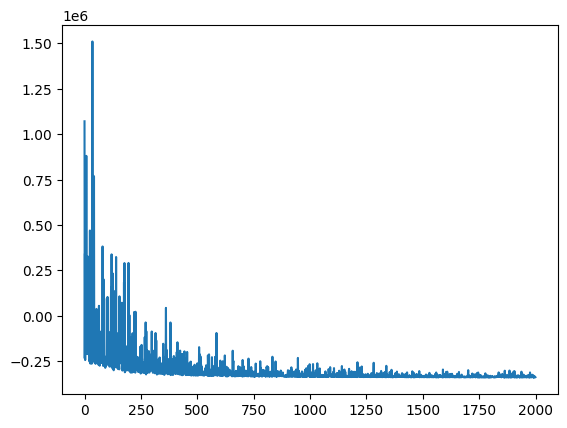

In [17]:
if developer_mode:
    pyro.clear_param_store

    guide_continuous = pyro.infer.autoguide.AutoDiagonalNormal(continuous_model)
    Adam = pyro.optim.Adam
    Trace_ELBO = pyro.infer.Trace_ELBO
    SVI = pyro.infer.SVI

    pyro.clear_param_store()
    svi = SVI(
        model=continuous_model,
        guide=guide_continuous,
        optim=Adam({"lr": 0.01}),
        loss=Trace_ELBO(),
    )

    losses = []
    num_steps = num_iterations
    for step in range(num_steps):
        loss = svi.step(
            proximity_tensor, trace_tensor, communicate_tensor, how_far_tensor
        )
        losses.append(loss)
        if step % 100 == 0:
            print(f"Step {step}/{num_steps}, Loss: {loss}")

    plt.plot(losses)

In [18]:
if developer_mode:
    locust_data_folder = os.path.join(root, "data/foraging/locust/")
    locust_continuous_samples_path = os.path.join(
        locust_data_folder,
        f"locust_cont__samples_iter{num_iterations}_lsamples{locust_sample_size}.pkl",
    )

    sites = ["bias", "p", "t", "c"]

    num_samples = num_samples
    predictive_continuous = pyro.infer.Predictive(
        model=continuous_model,
        guide=guide_continuous,
        num_samples=num_samples,
        return_sites=sites,
    )

    samples_continuous = predictive_continuous(
        proximity_tensor, trace_tensor, communicate_tensor, how_far_tensor
    )

    with open(locust_continuous_samples_path, "wb") as f:
        pickle.dump(samples_continuous, f)

In [19]:
if not developer_mode:
    locust_data_folder = os.path.join(root, "data/foraging/locust/")
    locust_continuous_samples_path = os.path.join(
        locust_data_folder,
        f"locust_cont__samples_iter2000_lsamples178770.pkl",
    )


with open(locust_continuous_samples_path, "rb") as f:
    samples_continuous = pickle.load(f)

svi_samples = samples_continuous.copy()
svi_samples.pop("bias")

ft.plot_coefs(
    svi_samples,
    title="Locust model coefficients",
    nbins=80,
    ann_start_y=160,
    ann_break_y=10,
)

In [20]:
# note that while the impact of communication is detected
# the model as a whole is not amazing at predicting how far
# this is not surprising as linear regression is a rough approximation here

simulated_outcome = (
    samples_continuous["bias"]
    + samples_continuous["p"] * proximity_tensor
    + samples_continuous["t"] * trace_tensor
    + samples_continuous["c"] * communicate_tensor
)

mean_sim_outcome = simulated_outcome.mean(0).detach().cpu().numpy()
observed_mean = torch.mean(how_far_tensor)
tss = torch.sum((how_far_tensor - observed_mean) ** 2)
rss = torch.sum((how_far_tensor - mean_sim_outcome) ** 2)
r_squared = 1 - (rss / tss)

print("r squared is:", r_squared.float().item())

notebook_ends = time.time()
print(
    "notebook took",
    notebook_ends - notebook_starts,
    "seconds, that is ",
    (notebook_ends - notebook_starts) / 60,
    "minutes to run",
)

r squared is: 0.08759456872940063
notebook took 363.2058174610138 seconds, that is  6.0534302910168964 minutes to run
